# Estradiol: Main Paper Figure 3

## Defining Paths

In [1]:
from pathlib import Path

root = Path("../../")
molecule = "estradiol"

# Path to the 2DJ dataset
# Under this directory, NMR-EsPy expects a ser file, an acqus file, and an acqu2s file to exist
data_dir = root / "data" / molecule / "1"

# Directory which results will be output to
output_dir = root / "code" / molecule / "output"
output_dir.mkdir(exist_ok=True, parents=True)

## Importing and Pre-processing the Data

In [2]:
import nmrespy as ne

estimator_path = output_dir / "estimator.pkl"
if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_dir)
    estimator.phase_data(p0=4.563, p1=-6.239)
    estimator.to_pickle(estimator_path)

## Estimation

In [3]:
import numpy as np

np.random.seed(0)

rerun_estimation = False
try:
    if rerun_estimation:
        raise ValueError("Re-runnning estimation.")
    estimator.get_results()
except ValueError:
    regions = [
        (2.29, 2.17), (2.12, 2.00), (1.95, 1.72),
        (1.65, 1.52), (1.45, 1.02),
    ]
    estimate_kwargs = dict(
        noise_region=(8.1, 7.9),
        region_unit="ppm",
        max_iterations=100,
        check_neg_amps_every=25,
    )
    initial_guesses = [20, 15, 40, 20, 90]
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess,
            **estimate_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

## Plotting the Result

N.B. The 2DJ spectrum isn't visible due to its low SNR. Conventional processing using sinebell apodisation renders the spectrum too insensitive to see. In the paper, a spectrum generated using a higher-concentration sample is plotted.

In [4]:
import copy
import matplotlib.pyplot as plt

colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])[:4]
colors.append("#808080")

def get_colors(mp_indices):
    return [colors[i] for i in mp_indices]
    
default_plot_kwargs= dict(
    region_unit="ppm",
    multiplet_lw=0.8,
    marker_size=15.0,
    figsize=(12.0, 5.0),
    axes_left=0.1,
    axes_right=0.99,
    axes_bottom=0.11,
    axes_top=0.98,
    contour_base=8.0e3,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    multiplet_show_45=False,
    multiplet_show_center_freq=False,
    ratio_1d_2d=(3.0, 1.0),
    lb=2.0,
)

def plot_result(estimator, **kwargs):
    plot_kwargs = copy.deepcopy(default_plot_kwargs)
    for key, value in kwargs.items():
        plot_kwargs[key] = value
    fig, axs = estimator.plot_result(**plot_kwargs)
    return fig, axs

Multiplet threshold used: 1.992 Hz


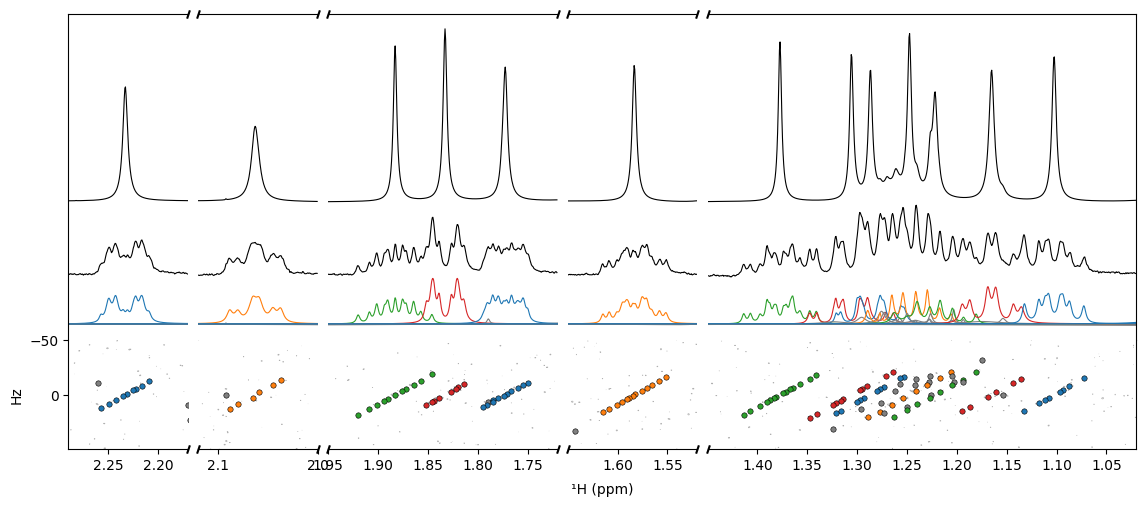

In [5]:
mp_thold = 2.55 * estimator.default_multiplet_thold
print("Multiplet threshold used: {:.3f} Hz".format(mp_thold))

multiplet_colors = get_colors(
    [4, 0, 4, 4, 4, 1, 4, 2, 3, 4, 0, 4, 1, 4, 4, 2, 3, 0, 4, 4, 4, 4, 1, 4, 4, 2, 4, 3, 4, 0]
)
plot_result(estimator, multiplet_thold=mp_thold, multiplet_colors=multiplet_colors);

In [6]:
params = estimator.get_params(funit="ppm")
spurious_indices = []
ppms = []
for f, idxs in estimator.predict_multiplets(thold=mp_thold).items():
    if len(idxs) == 1:
        idx = idxs[0]
        param = params[idx]
        if abs(param[2]) > mp_thold:
            spurious_indices.append(idx)
            ppms.append(param[3])
for ppm, idx in zip(ppms, spurious_indices):            
    print("{} ppm : {}".format(ppm, idx))

1.1936232948630814 ppm : 19
1.2279476004341283 ppm : 30
1.2573664220863394 ppm : 41
1.6429797522356495 ppm : 99
1.7895204965018618 ppm : 110
2.1676817081859 ppm : 140
2.169578294615298 ppm : 141
2.2598320960436844 ppm : 151


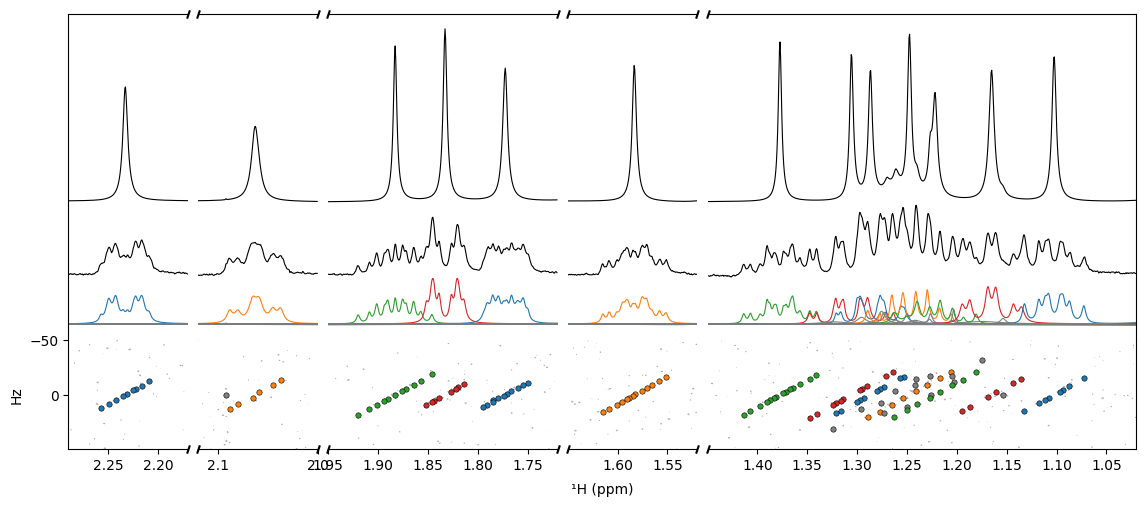

In [7]:
estimator.predict_multiplets(thold=mp_thold, rm_spurious=True)
multiplet_colors = get_colors(
    [0, 4, 1, 4, 2, 3, 0, 4, 1, 4, 2, 3, 0, 4, 4, 1, 4, 4, 2, 3, 4, 0, 4, 4]
)
plot_result(estimator, multiplet_thold=mp_thold, multiplet_colors=multiplet_colors);

## Manually Removing the Presistent Strong Coupling Artefacts 

Quite a few strong coupling signals have ended up in the final result, particular in the most shielded region (index `4`). Using a similar approach to the camphor example, these can be identified and removed, leading to a pure shift spectrum which is devoid of their influence. Again, such a proceure should not be undertaken lightly. Make sure any manual edits made are clearly documented.

In [8]:
multiplets = estimator.predict_multiplets(indices=[4], thold=mp_thold)
for i, (f_hz, indices) in enumerate(multiplets.items()):
    print("Multiplet #{}  {:.3f} ppm, {}".format(i, f_hz / estimator.sfo[1], indices))

Multiplet #0  1.001 ppm, [0]
Multiplet #1  1.015 ppm, [1]
Multiplet #2  1.102 ppm, [2, 3, 4, 5, 6, 7, 8, 9]
Multiplet #3  1.154 ppm, [12]
Multiplet #4  1.165 ppm, [10, 11, 13, 14, 17, 19]
Multiplet #5  1.222 ppm, [16, 18, 21, 24, 27, 30, 34, 40]
Multiplet #6  1.227 ppm, [20, 26, 35]
Multiplet #7  1.239 ppm, [15, 22, 44]
Multiplet #8  1.248 ppm, [23, 25, 29, 31, 37, 42, 48, 50]
Multiplet #9  1.261 ppm, [28, 33, 46, 64]
Multiplet #10  1.270 ppm, [32, 39, 54]
Multiplet #11  1.287 ppm, [36, 38, 45, 47, 49, 52, 55, 57, 60, 61]
Multiplet #12  1.306 ppm, [41, 43, 51, 53, 56, 58, 59, 62, 63, 65, 68]
Multiplet #13  1.377 ppm, [66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


In [9]:
spurious_idx = [0, 1, 3, 6, 7, 9, 10]
all_multiplets = list(multiplets.values())
to_rm = [all_multiplets[i] for i in spurious_idx]
# Merge list of lists to form list of indices
to_rm = [item for sublist in to_rm for item in sublist]
print("To remove: {}".format(to_rm))

To remove: [0, 1, 12, 20, 26, 35, 15, 22, 44, 28, 33, 46, 64, 32, 39, 54]


In [10]:
estimator.remove_oscillators(index=4, osc_indices=to_rm);

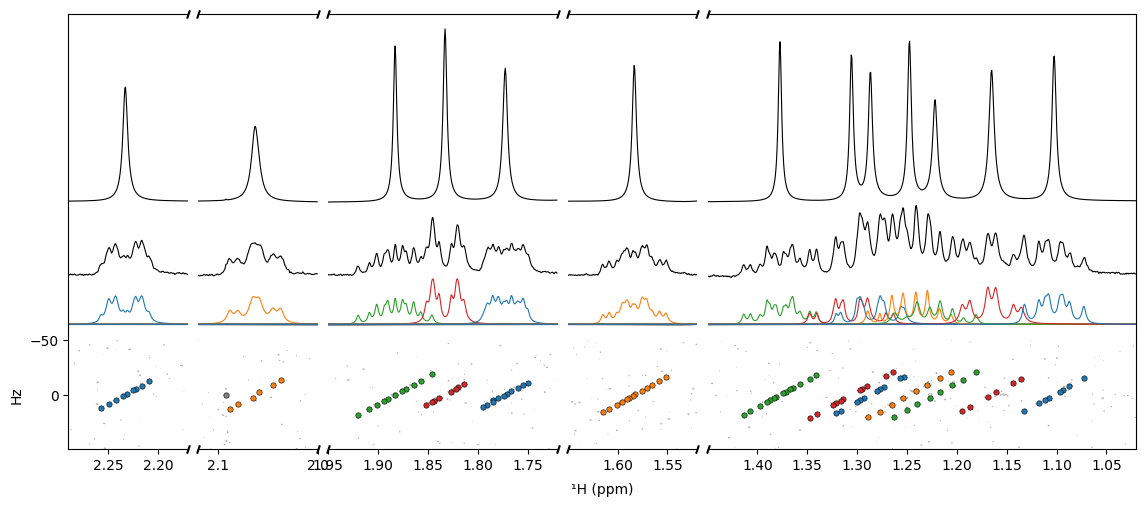

In [11]:
multiplet_colors = get_colors(
    [0, 4, 1, 4, 2, 3, 0, 4, 1, 4, 2, 3, 0, 1, 2, 3, 0]
)
plot_result(estimator, multiplet_thold=mp_thold, multiplet_colors=multiplet_colors);